In [1]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-8n64pbi9
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-8n64pbi9
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8302 sha256=7f7117d0cdd20ef6cad41abd95a51f8bb67a3be3c5ac98d14b8108f3c842c9ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-vmj9abrk/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Dense, Flatten, Dropout
from keras.optimizers import Adam
import keras.backend as K

from keras_vggface.vggface import VGGFace
from keras_vggface import utils

import os
import pandas as pd
import numpy as np
from tqdm import tqdm as pbar

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
ROOT_DIR = "/kaggle/input/faceexpression-dp"
CSV_FILE = os.path.join(ROOT_DIR, "data.csv")
IMAGE_DIR = os.path.join(ROOT_DIR, "dataset")

data = pd.read_csv(CSV_FILE)
data.head()

,Unnamed: 0,path,label
0,0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


In [5]:
# VGG friendly image shape
IMAGE_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

In [6]:
image_datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.2
)

train_datagen = image_datagen.flow_from_dataframe(
    data,
    directory=IMAGE_DIR,
    x_col="path",
    y_col="label",
    target_size = IMAGE_SHAPE[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    subset = 'training'
)

val_datagen = image_datagen.flow_from_dataframe(
    data,
    directory=IMAGE_DIR,
    x_col="path",
    y_col="label",
    target_size = IMAGE_SHAPE[:2],
    batch_size = BATCH_SIZE,
    subset = 'validation'
)

Found 12363 validated image filenames belonging to 6 classes.
Found 3090 validated image filenames belonging to 6 classes.


In [7]:
class_index = val_datagen.class_indices
index_class = {v:k for k, v in class_index.items()}
NUM_CLASSES = len(class_index)
print(class_index)

{'Ahegao': 0, 'Angry': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}


Image shape: (32, 224, 224, 3)


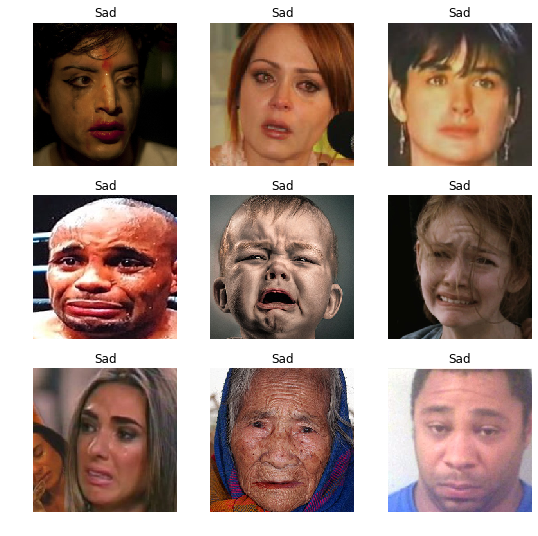

In [8]:
for image, label in val_datagen:
    print("Image shape:", image.shape)
    
    plt.figure(figsize=(9, 9))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        
        index = np.argmax(label[i])
        plt.title(f"{index_class[index]}")
        plt.imshow((image[i]*255).astype('uint8'))
        plt.axis('off')
    
    plt.show()
    
    break

## Model Building

In [9]:
# Default value for unfreeze_layer is set to -3 because last most layer is global avg pooling, 
# last second layer is MaxPooling and last 3rd layer is convolution hence -3
def build_model(image_shape, num_classes, unfreeze_layers=-3, drop_rate=0.5):
    
    input_layer = Input(shape=image_shape)
    vgg_base_model = VGGFace(include_top = False, input_shape = image_shape, pooling='avg')
    
    # Freeze all the layers till unfreeze layers
    for layer in vgg_base_model.layers[:unfreeze_layers]:
        layer.trainable = False
    
    for layer in vgg_base_model.layers[unfreeze_layers:]:
        layer.trainable = True
    
    x = vgg_base_model(input_layer)
    
    x = Dropout(drop_rate)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[input_layer], outputs=[output], name="Expression_Classifier")
    return model

In [9]:
LR = 1e-5

model1 = build_model(IMAGE_SHAPE, NUM_CLASSES)
optimizer = Adam(lr=LR)

model1.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy']
)

58916864/58909280 [==============================] - 3s 0us/step


In [10]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
vggface_vgg16 (Model)        (None, 512)               14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 2,362,886
Non-trainable params: 12,354,880
_________________________________________________________________


In [11]:
file_path = 'vgg_face_weights.h5'
model_checkpoint = ModelCheckpoint(
    file_path,
    monitor='val_loss',
    verbose=1,
    save_best_only = True,
    mode = 'min'
)

reduce_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    mode = "min",
    factor = 0.001,
    patience = 3,
    verbose=1
)

In [12]:
EPOCHS = 10
train_steps = len(train_datagen)
val_steps = len(val_datagen)
hist1 = model1.fit_generator(train_datagen, validation_data=val_datagen, epochs=EPOCHS, verbose = 1, 
                             steps_per_epoch = train_steps, validation_steps = val_steps, workers=2, 
                             use_multiprocessing=True)

Epoch 1/10
387/387 [==============================] - 147s 380ms/step - loss: 1.5400 - acc: 0.3843 - val_loss: 2.7786 - val_acc: 0.0000e+00
Epoch 2/10
387/387 [==============================] - 150s 387ms/step - loss: 1.3606 - acc: 0.4612 - val_loss: 2.9327 - val_acc: 0.0033
Epoch 3/10
387/387 [==============================] - 92s 237ms/step - loss: 1.2124 - acc: 0.5612 - val_loss: 3.1604 - val_acc: 0.0226
Epoch 4/10
387/387 [==============================] - 86s 221ms/step - loss: 1.1314 - acc: 0.5926 - val_loss: 3.1885 - val_acc: 0.0650
Epoch 5/10
387/387 [==============================] - 86s 223ms/step - loss: 1.0578 - acc: 0.6245 - val_loss: 3.1970 - val_acc: 0.1833
Epoch 6/10
387/387 [==============================] - 84s 218ms/step - loss: 0.9832 - acc: 0.6608 - val_loss: 3.3077 - val_acc: 0.1167
Epoch 7/10
387/387 [==============================] - 85s 221ms/step - loss: 0.9466 - acc: 0.6695 - val_loss: 3.4353 - val_acc: 0.1782
Epoch 8/10
387/387 [=============================

In [10]:
def visualize_training(history):
    plt.figure(figsize=(18, 7))
    # Extract the metrics to visulalize
    metrics = []

    # Getting all the metrics we have while model training
    hist_metrics = history.history.keys()
    for item in hist_metrics:
        if item.startswith("val"):
            continue

        metrics.append(item)


    for indx, metric in enumerate(metrics):
        title = f'{metric}'
        legends = [metric]
        plt.subplot(1, len(metrics), indx+1)
        plt.plot(history.history[metric], label=metric, marker='o')

        val_metric = 'val_' + metric
        if val_metric in hist_metrics:
            title += f" vs {val_metric}"
            plt.plot(history.history[val_metric], label=val_metric, marker='^')
            legends.append(val_metric)

        plt.legend(legends)
        plt.grid(True)
        plt.title(title)

    plt.show()

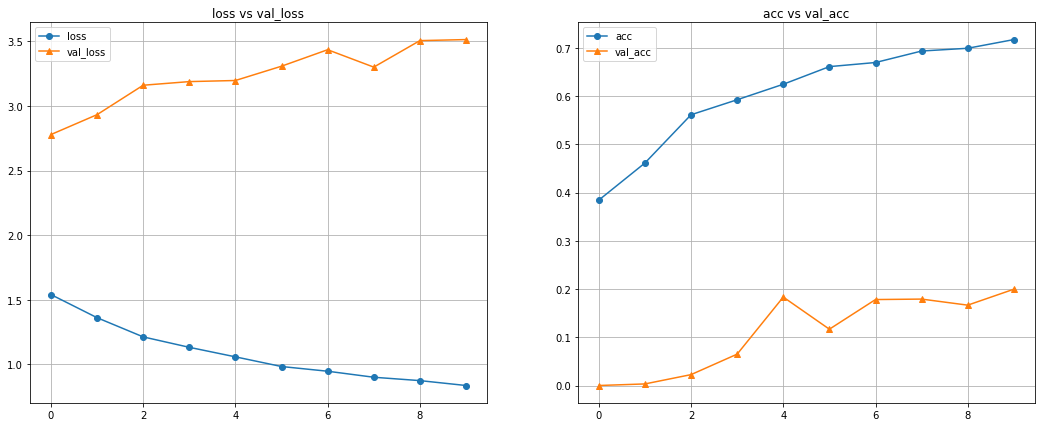

In [14]:
visualize_training(hist1)

In [11]:
def get_preds(model, val_datagen):

    # Get the prediction for the test_dataset
    true_labels_probs = []
    pred_labels_probs = []
    val_steps = len(val_datagen)

    for indx, (img, label) in enumerate(val_datagen):
        true_labels_probs.extend(label)

        preds = model.predict(img, verbose=0)
        pred_labels_probs.extend(preds)

        if indx+1 > val_steps:
            break

    true_labels_probs = np.array(true_labels_probs)
    pred_labels_probs = np.array(pred_labels_probs)

    true_label_cat = np.argmax(true_labels_probs, axis=-1)
    pred_label_cat = np.argmax(pred_labels_probs, axis=-1)

    return true_labels_probs, true_label_cat, pred_labels_probs, pred_label_cat

In [16]:
train_true_probs, train_true_label, train_pred_probs, train_pred_label = get_preds(model1, train_datagen)

In [25]:
max_labels = np.unique(train_true_label)[-1]
labels = list(class_index.keys())[:max_labels+1]
train_clf_report = classification_report(train_true_label, train_pred_label, target_names=labels)
print("Training Classification Report \n", train_clf_report)

Training Classification Report 
               precision    recall  f1-score   support

      Ahegao       0.87      0.93      0.90      1207
       Angry       0.74      0.41      0.53      1318
       Happy       0.86      0.89      0.87      3746
     Neutral       0.66      0.88      0.75      4041
         Sad       0.66      0.35      0.46      2083

    accuracy                           0.75     12395
   macro avg       0.76      0.69      0.70     12395
weighted avg       0.75      0.75      0.73     12395



In [12]:
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.show()

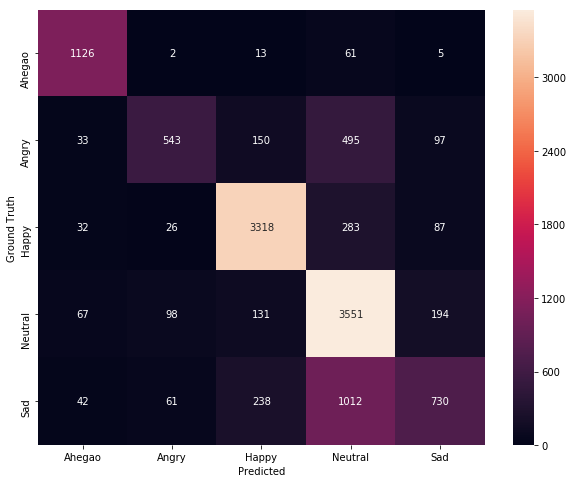

In [31]:
conf_matrix1 = confusion_matrix(train_true_label, train_pred_label)
plot_confusion_matrix(conf_matrix1, labels)

In [13]:
def plot_roc_curve(cat_label, y_true, y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    plt.figure(figsize=(10, 10))
    for i, label in enumerate(cat_label):
        # Calculate the False Positive and True Positive rate for each class individually
        fpr[label], tpr[label], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plotting the metrics
    plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-avg ROC curve (area = {roc_auc['micro']:.2f})")

    # Plot all class FPR and TPR rates
    for label in cat_label:
        plt.plot(fpr[label], tpr[label], lw=2, label=f'ROC Curve of {label} (area = {roc_auc[label]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for each class")
    plt.legend(loc='lower right')
    plt.show()

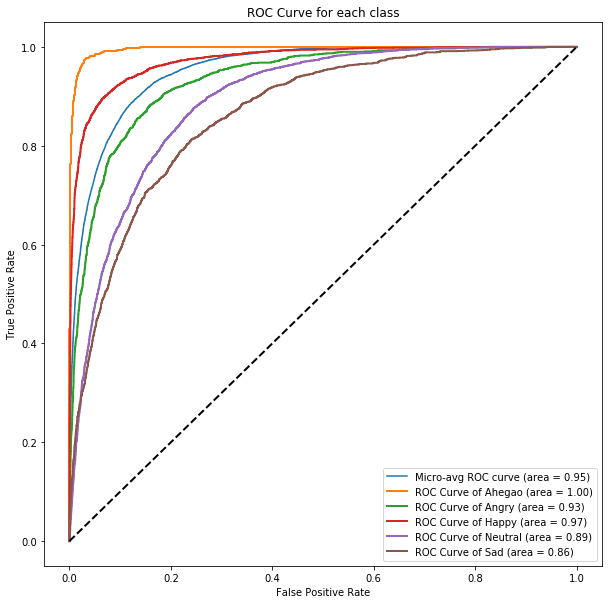

In [41]:
plot_roc_curve(labels, train_true_probs, train_pred_probs)

In [42]:
test_true_probs, test_true_label, test_pred_probs, test_pred_label = get_preds(model1, val_datagen)

In [45]:
labels = list(class_index.keys())
test_clf_report = classification_report(test_true_label, test_pred_label, target_names=labels)
print("Test Classification Report\n", test_clf_report)

Test Classification Report
               precision    recall  f1-score   support

      Ahegao       0.00      0.00      0.00         0
       Angry       0.00      0.00      0.00         0
       Happy       0.00      0.00      0.00         0
     Neutral       0.00      0.00      0.00         0
         Sad       0.90      0.33      0.48      1884
    Surprise       0.00      0.00      0.00      1238

    accuracy                           0.20      3122
   macro avg       0.15      0.06      0.08      3122
weighted avg       0.54      0.20      0.29      3122



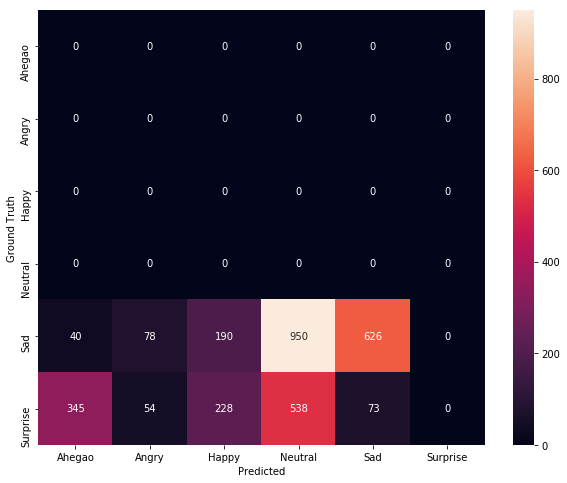

In [46]:
conf_matrix_test1 = confusion_matrix(test_true_label, test_pred_label)
plot_confusion_matrix(conf_matrix_test1, labels)

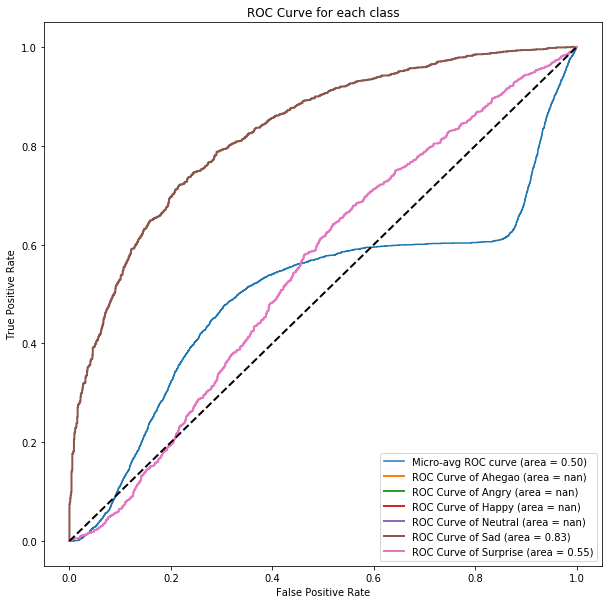

In [47]:
plot_roc_curve(labels, test_true_probs, test_pred_probs)

The model is drastically performing worse on the validation dataset which is seen from the training plot as well as the model is widely overfitting. Now in order to overcome this we can add data augmentation which will be our only retort. 

In [14]:
data2 = data.copy()
data2 = data2.sample(frac=1).reset_index(drop=True)

In [16]:
image_datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.2,
    rotation_range=45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True
)

train_datagen = image_datagen.flow_from_dataframe(
    data2,
    directory=IMAGE_DIR,
    x_col="path",
    y_col="label",
    target_size = IMAGE_SHAPE[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    subset = 'training'
)

val_datagen = image_datagen.flow_from_dataframe(
    data2,
    directory=IMAGE_DIR,
    x_col="path",
    y_col="label",
    target_size = IMAGE_SHAPE[:2],
    batch_size = BATCH_SIZE,
    subset = 'validation'
)

Found 12363 validated image filenames belonging to 6 classes.
Found 3090 validated image filenames belonging to 6 classes.


In [17]:
class_index = val_datagen.class_indices
index_class = {v:k for k, v in class_index.items()}
NUM_CLASSES = len(class_index)
print(class_index)

{'Ahegao': 0, 'Angry': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}


Image shape: (32, 224, 224, 3)


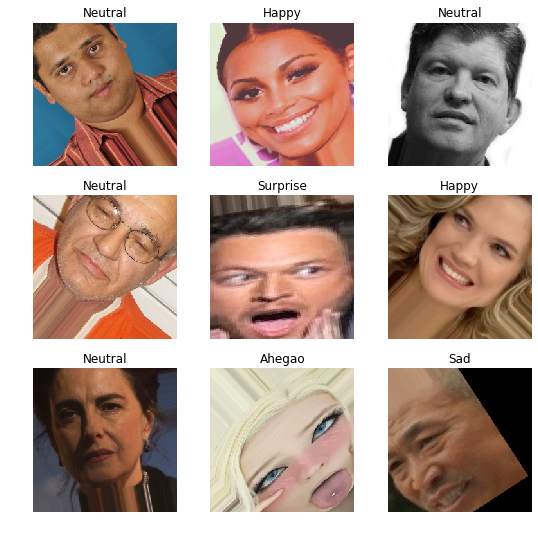

In [18]:
for image, label in val_datagen:
    print("Image shape:", image.shape)
    
    plt.figure(figsize=(9, 9))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        
        index = np.argmax(label[i])
        plt.title(f"{index_class[index]}")
        plt.imshow((image[i]*255).astype('uint8'))
        plt.axis('off')
    
    plt.show()
    
    break

In [19]:
LR = 1e-5

model2 = build_model(IMAGE_SHAPE, NUM_CLASSES)
optimizer = Adam(lr=LR)

model2.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy']
)

model2.summary()

58916864/58909280 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
vggface_vgg16 (Model)        (None, 512)               14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 2,362,886
Non-trainable params: 12,354,880
_________________________________________________________________


In [21]:
file_path = 'vgg_face_weights2.h5'
model_checkpoint = ModelCheckpoint(
    file_path,
    monitor='val_loss',
    verbose=1,
    save_best_only = True,
    mode = 'min'
)

reduce_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    mode = "min",
    factor = 0.001,
    patience = 3,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor = "val_loss",
    min_delta = 1e-3,
    patience = 5,
)

In [23]:
EPOCHS = 25
train_steps = len(train_datagen)
val_steps = len(val_datagen)
hist2 = model2.fit_generator(train_datagen, validation_data=val_datagen, epochs=EPOCHS, verbose = 1, 
                             steps_per_epoch = train_steps, validation_steps = val_steps, workers=2, 
                             use_multiprocessing=True, callbacks=[model_checkpoint, reduce_on_plateau, early_stopping])

Epoch 1/25
387/387 [==============================] - 251s 648ms/step - loss: 1.6698 - acc: 0.3152 - val_loss: 1.6089 - val_acc: 0.4062

Epoch 00001: val_loss improved from inf to 1.60887, saving model to vgg_face_weights2.h5
Epoch 2/25
387/387 [==============================] - 240s 621ms/step - loss: 1.5767 - acc: 0.3914 - val_loss: 1.5534 - val_acc: 0.4125

Epoch 00002: val_loss improved from 1.60887 to 1.55338, saving model to vgg_face_weights2.h5
Epoch 3/25
387/387 [==============================] - 181s 467ms/step - loss: 1.5140 - acc: 0.4318 - val_loss: 1.4805 - val_acc: 0.4436

Epoch 00003: val_loss improved from 1.55338 to 1.48053, saving model to vgg_face_weights2.h5
Epoch 4/25
387/387 [==============================] - 182s 470ms/step - loss: 1.4533 - acc: 0.4481 - val_loss: 1.4209 - val_acc: 0.4802

Epoch 00004: val_loss improved from 1.48053 to 1.42085, saving model to vgg_face_weights2.h5
Epoch 5/25
387/387 [==============================] - 183s 473ms/step - loss: 1.3895

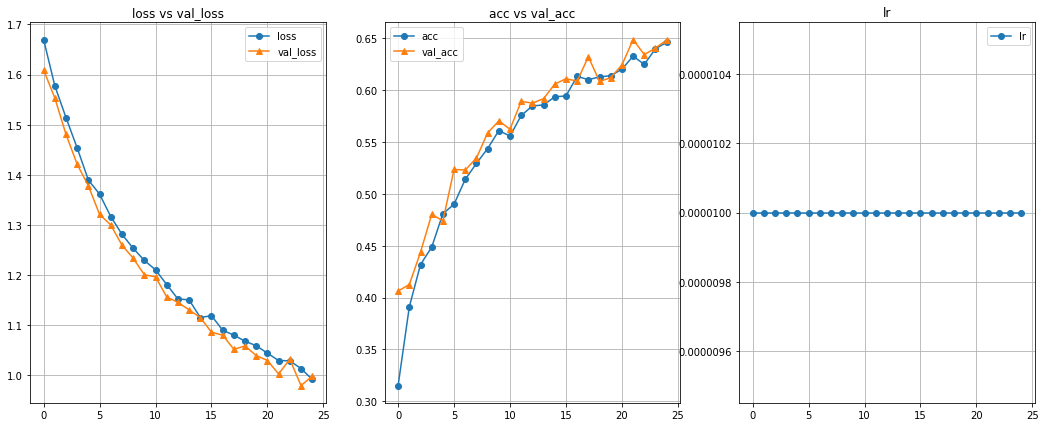

In [24]:
visualize_training(hist2)

In [25]:
test_true_probs, test_true_label, test_pred_probs, test_pred_label = get_preds(model2, val_datagen)

In [26]:
labels = list(class_index.keys())
test_clf_report = classification_report(test_true_label, test_pred_label, target_names=labels)
print("Test Classification Report\n", test_clf_report)

Test Classification Report
               precision    recall  f1-score   support

      Ahegao       0.72      0.83      0.77       240
       Angry       0.71      0.20      0.31       273
       Happy       0.78      0.82      0.80       749
     Neutral       0.55      0.72      0.62       810
         Sad       0.59      0.56      0.58       808
    Surprise       0.68      0.42      0.52       242

    accuracy                           0.64      3122
   macro avg       0.67      0.59      0.60      3122
weighted avg       0.65      0.64      0.63      3122



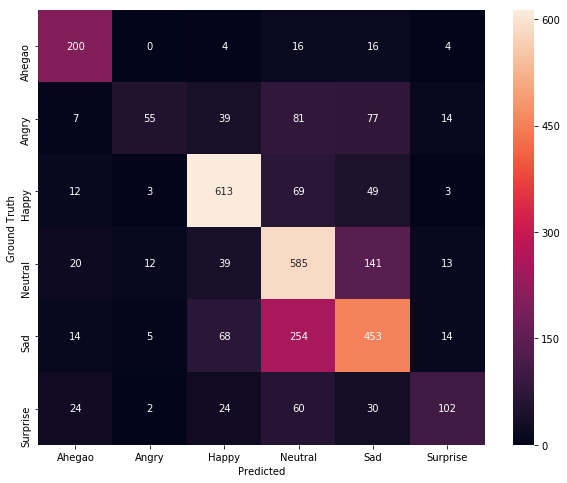

In [27]:
conf_matrix_test2 = confusion_matrix(test_true_label, test_pred_label)
plot_confusion_matrix(conf_matrix_test2, labels)

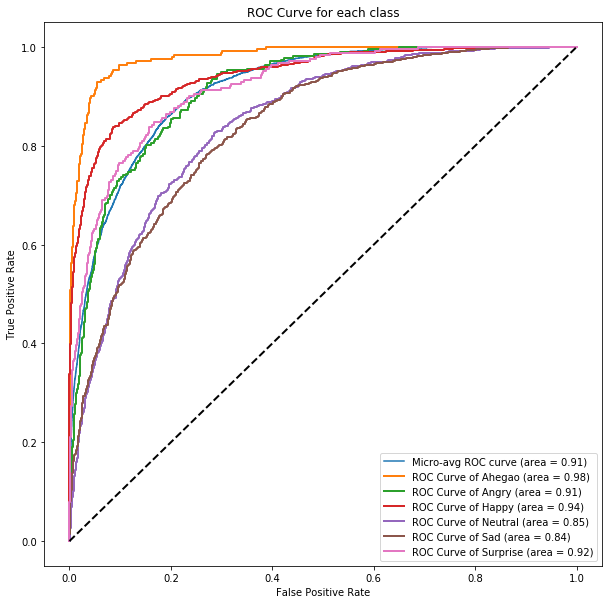

In [28]:
plot_roc_curve(labels, test_true_probs, test_pred_probs)